# Wavenet

https://arxiv.org/abs/1609.03499

# 초기 세팅

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
names = open('../names.txt').read().splitlines()
print(len(names))
print(max(len(n) for n in names))
print(names[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(names)

In [5]:
block_size = 8

# build the dataset
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size

        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# 임베딩, Sequantial 레이어 만들기

이전 MLP 강의에서 임베딩 레이어는 `layers` 리스트에 포함되지 않고

따로 `C = torch.randn()`으로 초기화했습니다.

통일성이 없어요! 같이 `layers`에 포함하도록 만듭시다.

In [7]:
# 원래 만들었던 코드
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaimaing init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # parameters trained with running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var
        
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# 새로 만든 코드
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequantial:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

이제 layers 리스트 대신 Sequantial로 임베딩까지 한번에 다 포함

In [8]:
torch.manual_seed(42) # for reproducibility

n_embed = 10
n_hidden = 200

model = Sequantial([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    ])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0 :
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


5분 소요...

# loss plot 이쁘게 만들기

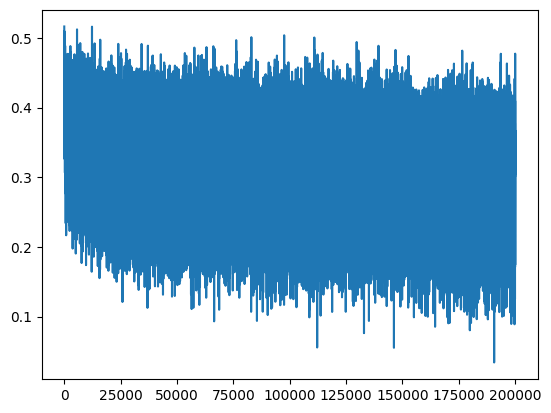

In [10]:
# 그냥 그리기
plt.plot(lossi)

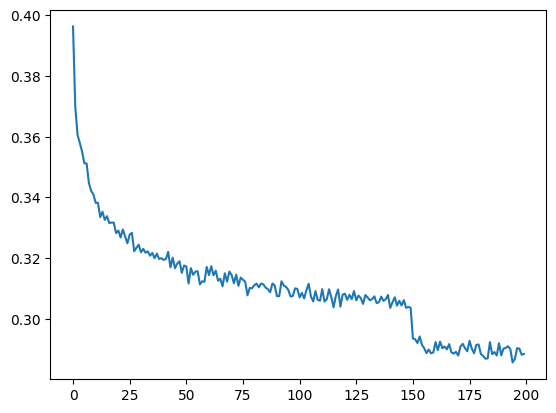

In [11]:
# 1000 스텝 당 평균
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# [optional] 추론/평가할 때 반드시 BatchNorm1D를 eval mode로 해야 함

batch norm 레이어 클래스 정의한거 보면

`training`이 디폴트로 `True`임

근데 추론할 때 `False`로 안해주면 에러 뜸

아래 처럼 추론해보면


In [ ]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix==0:    
            break
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
    
    print(''.join(itos[i] for i in out))

C:\Users\hyjun\AppData\Local\Temp\ipykernel_31784\1363989118.py:32: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  xvar = x.var(0, keepdim=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

배치 크기가 1임 → 학습 모드라 1개 값 배치에 대해 분산 구함 

→ 분산이 0이되는 것도 아니고 그냥 `nan`(1개 숫자에 대해 분산 구하면 `nan`으로 나옴…)

그래서 `training=False`로 해줘야 함

# 평가

In [12]:
model.layers[3].training = False

# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix==0:    
            break
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
    
    print(''.join(itos[i] for i in out))

yeverii
kya
kylek
tisire
porbyn
abib
merighlynn
loriel
jiildy
davryah
brone
thorder
nyleah
miromell
oluwase
josusas
ramia
herlio
delina
maclai


In [13]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9163434505462646
val 2.034247875213623


# wavenet 논문

https://arxiv.org/abs/1609.03499

## hierarchical 구조 vs 원래 구조

위 그림 보면 알겠지만 wavenet은

local 패턴 → global 패턴 인식하는 방법

CNN 계열이 많이 쓰는 방법임 (receptive field가 점점 지수적으로 증가)

지난 시간에 만들었던 MLP 구조는 context window에 있는 임베딩 벡터를 그냥 concat함

## Flatten → FlattenConsecutive

In [14]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1]==1:
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [15]:
model = Sequantial([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
    ])

배치 크기 4일 때 텐서 모양 어케 바뀌는지 보자

In [16]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch size 4일 때 살펴보기
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [17]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


## computational efficiency

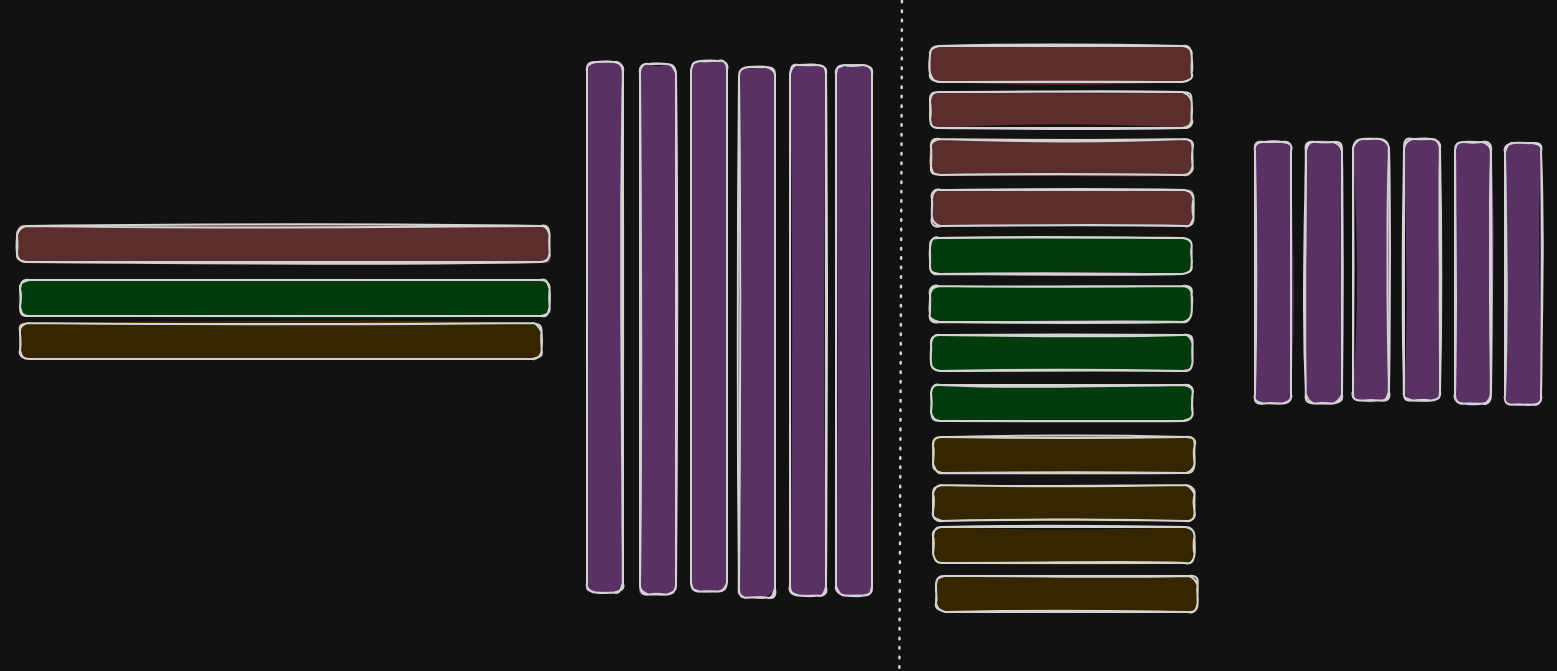

- 왼쪽: 지난 시간에 만들었던 MLP
    - 첫번째 행렬 연산 보면 `(B, T*E) @ (T*E, H)`
    - ex) `(32, 80) @ (80, 200) → (32, 200)`
    - 32행에 대한 행렬 곱 병렬처리
- 오른쪽: 이번 wavenet
    - 첫번째 행렬 연산 보면 `(B, T/2, E*2) @ (E*2, H)`
    - ex) `(32, 4, 20) @ (20, 68) → (32, 4, 68)`
    - **32X4에 대한 행렬 곱 병렬처리**
    - H(n_hidden) 줄어들어도 돼서 딥하게 레이어 쌓기 ㄱㄴ (원래 파라미터 수랑 비슷)
    - (CPU로 했을 때 학습 시간은 거의 2배긴 함… 연산량이 많음)
    - 딥하게 쌓으니 성능은 더 좋음 (local + global 피처 모두 고려)


# batch norm 수정

현재 그대로 배치 정규화 돌리는 예시

In [18]:
e = torch.randn((32, 4, 68))
emean = e.mean(0, keepdim=True)
evar = e.var(0, unbiased=True, keepdim=True)
ehat = (e-emean) / torch.sqrt(evar + 1e-5)
emean.shape, evar.shape, ehat.shape

(torch.Size([1, 4, 68]), torch.Size([1, 4, 68]), torch.Size([32, 4, 68]))

근데 원래 batch norm은 각 피처를 배치 방향으로 정규화하는 거임

위 예시면 평균하고 분산이 그냥 68차원이면 됨

굳이 4X68차원일 필요가 없음

- 4는 time step T라 볼 수 있는데, T 마다 분포 같다고 가정
- 왜냐면 어차피 hierarchical 구조라 Flatten된 로컬 피처만 중요
- 이 피처의 receptive field가 점점 커져서 다 커버하게 됨
- 그리고 그냥 68차원으로 하는게 계산 상으로도 이득

그래서 `dim=0`이 아닌 `dim=(0,1)`로 평균, 분산 구하면 됨

In [19]:
e = torch.randn((32, 4, 68))
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), unbiased=True, keepdim=True)
ehat = (e-emean) / torch.sqrt(evar + 1e-5)
emean.shape, evar.shape, ehat.shape

(torch.Size([1, 1, 68]), torch.Size([1, 1, 68]), torch.Size([32, 4, 68]))

이제 BatchNorm1d를 수정해봅시다!

In [22]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # parameters trained with running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)

            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var
        
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [25]:
model = Sequantial([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
    ])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


# 학습

In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #iupdate: simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0 :
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2880
  10000/ 200000: 2.2106
  20000/ 200000: 2.0506
  30000/ 200000: 2.1857
  40000/ 200000: 1.8200
  50000/ 200000: 2.2306
  60000/ 200000: 1.8772
  70000/ 200000: 2.1495
  80000/ 200000: 1.8151
  90000/ 200000: 1.8465
 100000/ 200000: 1.5652
 110000/ 200000: 1.9116
 120000/ 200000: 2.1483
 130000/ 200000: 2.0200
 140000/ 200000: 2.0702
 150000/ 200000: 1.8660
 160000/ 200000: 1.9333
 170000/ 200000: 1.4369
 180000/ 200000: 1.5721
 190000/ 200000: 1.3540


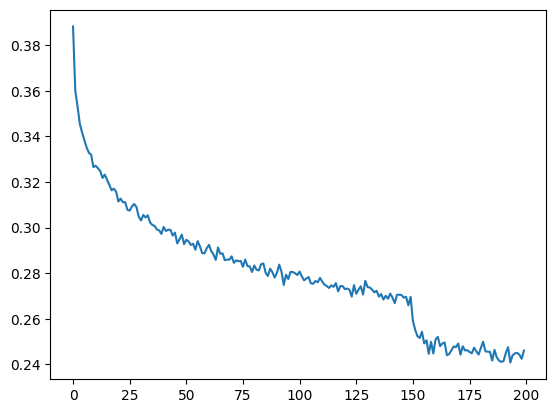

In [27]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# 평가

In [28]:
# put layers into eval mode (needed for BatchNorm1D especially)
for layer in model.layers:
    layer.training = False

In [29]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.73214852809906
val 1.9950121641159058


In [30]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix==0:    
            break
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
    
    print(''.join(itos[i] for i in out))


justaf
devid
taliden
yareli
azana
joson
maizen
martyn
elyanah
waaci
thudzo
huday
caston
grufya
kwati
dolson
kodi
zohaw
rigan
kyson
